## Copyright: <a href="https://www.cs.purdue.edu/homes/ribeirob/">Bruno Ribeiro</a> with help by S. Chandra Mouli
### Adapted for ML@Purdue Reading Group
----

# Learning G-Invariant Representations

## Setup

In [1]:
# All imports.
import torch
import numpy as onp
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import multiprocessing as mp
from functools import partial
from sklearn.metrics import balanced_accuracy_score
import torchvision.transforms.v2 as transforms
import copy


# Use notebook context for seaborn.
#sns.set_theme(context="notebook")


# Load MNIST data.
image_tensor, label_tensor = torch.load("mnist.pt")
image_array, label_array = image_tensor.numpy(), label_tensor.numpy()
num_images, height, width = image_array.shape


# Split into training, validation and test by famous 7/1/2.
# Just work on a single one fold.
indices, labels = onp.arange(len(label_array)), label_array
rest_indices, test_indices, rest_labels, test_labels = train_test_split(
    indices, labels,
    test_size=2 / (7 + 1 + 2), random_state=0, shuffle=True, stratify=labels,
)
train_indices, valid_indices, train_labels, valid_labels = train_test_split(
    rest_indices, rest_labels,
    test_size=1 / (7 + 1), random_state=0, shuffle=True, stratify=rest_labels,
)
train_image_array = image_array[train_indices]
train_label_array = label_array[train_indices]
valid_image_array = image_array[valid_indices]
valid_label_array = label_array[valid_indices]
test_image_array = image_array[test_indices]
test_label_array = label_array[test_indices]


# Augment test by rotations.
aug_image_buf = []
aug_label_buf = []
for degree in (0, 90, 180, 270):
    aug_image_buf.append(
        onp.rot90(
            test_image_array, degree // 90,
            axes=(1, 2),
        ),
    )
    aug_label_buf.append(test_label_array)
aug_test_image_array = onp.concatenate(
    aug_image_buf,
    axis=0,
)
aug_test_label_array = onp.concatenate(
    aug_label_buf,
    axis=0,
)


# Define 90-rotation function.
def rotate_array(array, degree):
    if (array.ndim == 2 and degree % 90 == 0):
        return onp.rot90(array, degree // 90)
    else:
        print("Can only rorate 2D array by 90n degrees.")
        raise RuntimeError


# Define average of 4 rotations (0, 90, 180, 270) function.
def averaged_four_rotations(array):
    buf = []
    for degree in (0, 90, 180, 270):
        buf.append(rotate_array(array, degree))
    return sum(buf) / len(buf)


# Define focusing label.
FOCUS_LABEL = 3
FIRST_TRAIN_FOCUS = onp.where(train_label_array == FOCUS_LABEL)[0][0]
FIRST_VALID_FOCUS = onp.where(valid_label_array == FOCUS_LABEL)[0][0]
FIRST_TEST_FOCUS = onp.where(test_label_array == FOCUS_LABEL)[0][0]


# # Render an image with four rotations as example.
# # Use pandas.DataFrame to fit for seaborn.
# render_table = {"Degree": [], "Image": []}
# example_image = image_array[FIRST_TRAIN_FOCUS]
# example_label = label_array[FIRST_TRAIN_FOCUS].item()
# for degree in (0, 90, 180, 270):
#     rotated_example_image = rotate_array(example_image, degree)
#     render_table["Degree"].append(degree)
#     render_table["Image"].append(rotated_example_image)
# render_frame = pd.DataFrame(render_table)
# grid = sns.FacetGrid(
#     render_frame,
#     col="Degree", col_wrap=2, hue="Degree",
# )
# grid.map(
#     lambda df, *args, **kwargs: sns.heatmap(
#         df.values[0],
#         cmap="gray", cbar=False, square=True,
#     ),
#     "Image",
# )
# for ax, degree in zip(grid.axes.flat, (0, 90, 180, 270)):
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)
#     ax.set_title(
#         "Rotation Degree = {:d}$^\\circ$".format(degree),
#         fontdict=dict(fontsize=12),
#     )
# grid.fig.suptitle(
#     "Label = {:d}".format(example_label),
#     fontsize=16,
# )
# grid.tight_layout()
# grid.savefig("example_image.png")
# plt.close("all")

def showSubspace(subspace, Wshape, ndim=-1, channels=False):
    subspace = subspace.T

    if ndim == -1:
        ndim = subspace.shape[0]
    subspace = subspace[:ndim]

    ndim = subspace.shape[0]
    maxCols = min(ndim, 4)

    for j in range(ndim):
        if j % maxCols == 0:
            plt.show()
            nCols = maxCols if ndim - j > maxCols else ndim - j
            fig, axes = plt.subplots(1, nCols, figsize=(12 * nCols // 2, 9 // 2))
            try:
                axes[0]
            except:
                axes = [axes]

        kernel = subspace[j]
        kernel = kernel.reshape(*Wshape)

        if len(kernel.shape) == 3:
            kernel = kernel.transpose(1, 2, 0)
            if channels:
                kernel = np.concatenate([kernel[:, :, c] for c in range(kernel.shape[-1])], axis=1)
                axes[j%maxCols].add_patch(patches.Rectangle((-0.45, -0.45), 2.95, 2.95, facecolor='none', linestyle='--', linewidth=2, edgecolor='tab:red'))
                axes[j%maxCols].add_patch(patches.Rectangle((2.55, -0.45), 2.95, 2.95, facecolor='none', linestyle='--', linewidth=2, edgecolor='tab:green'))
                axes[j%maxCols].add_patch(patches.Rectangle((5.55, -0.45), 2.95, 2.95, facecolor='none', linestyle='--', linewidth=2, edgecolor='tab:blue'))

        axes[j%maxCols].imshow(kernel.round(decimals=6), cmap="Greys")
        axes[j%maxCols].set_xticklabels([0] + [0, 1, 2] * 3)

    plt.show()



# Construct specified onehot for flattened image and apply rotation.
def transformed_onehot(onehot_loc, transform_func, shape):
    # Get flattened onehot.
    numel = onp.prod(shape)
    onehot = onp.zeros(numel)
    onehot[onehot_loc] = 1

    # Transform onehot with specific shape view and flatten back.
    transformed_vec = transform_func(onehot.reshape(*shape))
    return transformed_vec.reshape(numel)


# Define number of CPUs to use for subspace generation.
NUM_TRANSFORM_CPUS = 12


# Apply given transformation on onehot corresponding to each pixel of 2D image.
# Use Python multiprocessing since it is work with numpy array.
# If it is torch Tensor, it is recommended to use PyTorch wrapped version of
# multiprocessing (torch.multiprocessing).
def get_invariant_subspace(transform_func, shape):
    # Use multiprocessing to get transformation matrix correspond to given
    # transformation function by paralleling onehot dimensions.
    numel = onp.prod(shape)
    pool = mp.Pool(NUM_TRANSFORM_CPUS)
    transformed_buf = pool.map(
        partial(
            transformed_onehot,
            transform_func=transform_func, shape=shape,
        ),
        range(numel),
    )
    pool.close()
    pool.join()
    transform_mat = onp.stack(
        transformed_buf,
        axis=1,
    )

    # Eigenvectors is used to describe the transformation subspace.
    # Use right side of decomposition thus eigenvectors are located at rows.
    # Transformation matrix is assumed to be real symmetric, thus Hermitian is
    # used for optimization.
    _, eigenvalues, eigenvectors = onp.linalg.svd(
        transform_mat,
        hermitian=True,
    )

    # Eigenvalues are sorted from high to low, thus for over rank eigenvectors,
    # they are null eigenvectors assigned with 0 eigenvalues.
    # We should focus on non-trival eigenvectors.
    rank = onp.linalg.matrix_rank(
        onp.diag(eigenvalues),
        hermitian=True,
    )
    ntri_eigenvectors = eigenvectors[:rank]
    null_eigenvectors = eigenvectors[rank:]
    return transform_mat, ntri_eigenvectors.T, null_eigenvectors.T, eigenvalues



# Define the test.
def accuracy(model, input, target):
    output = model.forward(input)
    _, predict = torch.max(
        output,
        dim=1,
    )
    return balanced_accuracy_score(
        y_true=target.tolist(), y_pred=predict.tolist(),
    )


# Prepare tensors.
train_input = torch.from_numpy(train_image_array).float()
train_input = train_input.view(len(train_label_array), height * width)
train_target = torch.from_numpy(train_label_array).long()
valid_input = torch.from_numpy(valid_image_array).float()
valid_input = valid_input.view(len(valid_label_array), height * width)
valid_target = torch.from_numpy(valid_label_array).long()
test_input = torch.from_numpy(test_image_array).float()
test_input = test_input.view(len(test_label_array), height * width)
test_target = torch.from_numpy(test_label_array).long()
aug_test_input = torch.from_numpy(aug_test_image_array).float()
aug_test_input = aug_test_input.view(len(aug_test_label_array), height * width)
aug_test_target = torch.from_numpy(aug_test_label_array).long()


# Global training settings.
BATCH_SIZE = 128
LR = 1e-3
WDECAY = 5e-5
NUM_EPOCHS = 100
NUM_BATCHES = len(train_input) // BATCH_SIZE
NUM_SAMPLES = NUM_BATCHES * BATCH_SIZE

/tmp/ipykernel_16413/1135210783.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image_tensor, label_tensor = torch.load("mnist.pt")


In [2]:
# Define 90-rotation function.
def rotate_array(array, degree):
    if (array.ndim == 2 and degree % 90 == 0):
        return onp.rot90(array, degree // 90)
    else:
        print("Can only rorate 2D array by 90n degrees.")
        raise RuntimeError


# Define average of 4 rotations (0, 90, 180, 270) function.
def averaged_four_rotations(array):
    buf = []
    for degree in (0, 90, 180, 270):
        buf.append(rotate_array(array, degree))
    return sum(buf) / len(buf)



In [3]:
# Define number of CPUs to use for subspace generation.
NUM_TRANSFORM_CPUS = 4

#Important variables
#  - transform_mat is out Reynods operator \bar{T}
#  - null_eigenvectors are the eigenvectors of \bar{T}

# Apply given transformation on onehot corresponding to each pixel of 2D image.
# Use Python multiprocessing since it is work with numpy array.
# If it is torch Tensor, it is recommended to use PyTorch wrapped version of
# multiprocessing (torch.multiprocessing).
def get_invariant_subspace(transform_func, shape):
    # Use multiprocessing to get transformation matrix correspond to given
    # transformation function by paralleling onehot dimensions.
    numel = onp.prod(shape)
    pool = mp.Pool(NUM_TRANSFORM_CPUS)
    transformed_buf = pool.map(
        partial(
            transformed_onehot,
            transform_func=transform_func, shape=shape,
        ),
        range(numel),
    )
    pool.close()
    pool.join()
    
    # Form a single Reynods operator matrix from all results
    transform_mat = onp.stack(transformed_buf,axis=1)

    # Eigenvectors is used to describe the transformation subspace.
    # Use right side of decomposition thus eigenvectors are located at rows.
    # Transformation matrix is assumed to be real symmetric, thus Hermitian is
    # used for optimization.
    _, eigenvalues, eigenvectors = onp.linalg.svd(transform_mat,hermitian=True)

    # Eigenvalues are sorted from high to low, thus for over rank eigenvectors,
    # they are null eigenvectors assigned with 0 eigenvalues.
    # We should focus on non-trival eigenvectors.
    rank = onp.linalg.matrix_rank(onp.diag(eigenvalues),hermitian=True)
    
    eigenvectors = eigenvectors[:rank]
    return transform_mat, eigenvectors.T


In [6]:
transform_mat.shape

(784, 784)

### Eigenvectors of the Reynolds Operator

The Reynolds operator tranformation matrix has dimension (784, 784)
The subspace W is the subspace span by 196 eigenvectors
--- First 16 eigenvectors shown as images ---


/tmp/ipykernel_16413/1135210783.py:157: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[j%maxCols].set_xticklabels([0] + [0, 1, 2] * 3)
/tmp/ipykernel_16413/1135210783.py:157: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[j%maxCols].set_xticklabels([0] + [0, 1, 2] * 3)
/tmp/ipykernel_16413/1135210783.py:157: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[j%maxCols].set_xticklabels([0] + [0, 1, 2] * 3)
/tmp/ipykernel_16413/1135210783.py:157: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[j%maxCols].set_xticklabels([0] + [0, 1, 2] * 3)


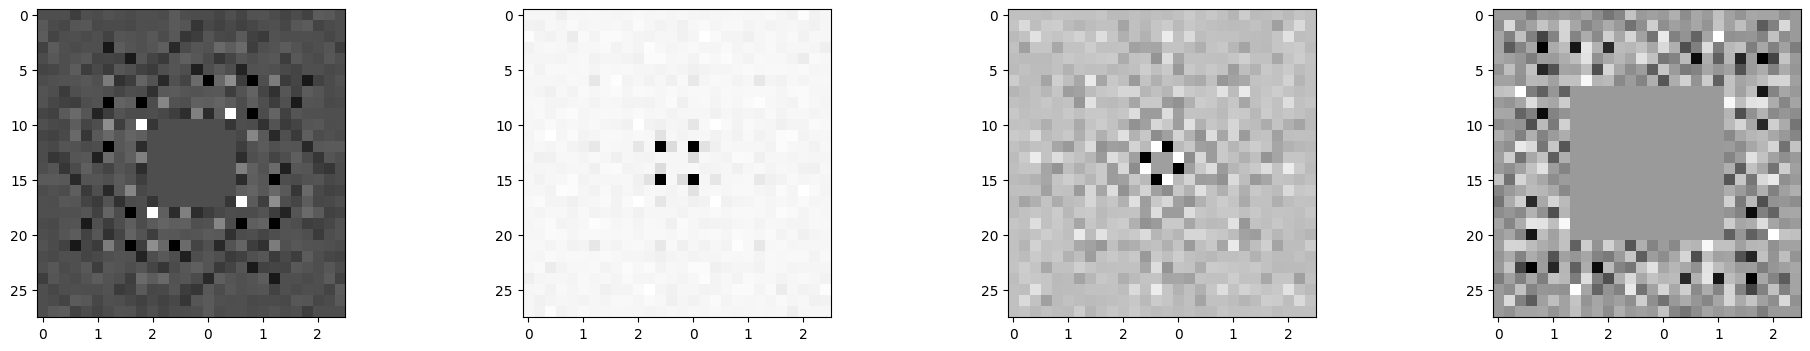

/tmp/ipykernel_16413/1135210783.py:157: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[j%maxCols].set_xticklabels([0] + [0, 1, 2] * 3)
/tmp/ipykernel_16413/1135210783.py:157: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[j%maxCols].set_xticklabels([0] + [0, 1, 2] * 3)
/tmp/ipykernel_16413/1135210783.py:157: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[j%maxCols].set_xticklabels([0] + [0, 1, 2] * 3)
/tmp/ipykernel_16413/1135210783.py:157: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[j%maxCols].set_xticklabels([0] + [0, 1, 2] * 3)


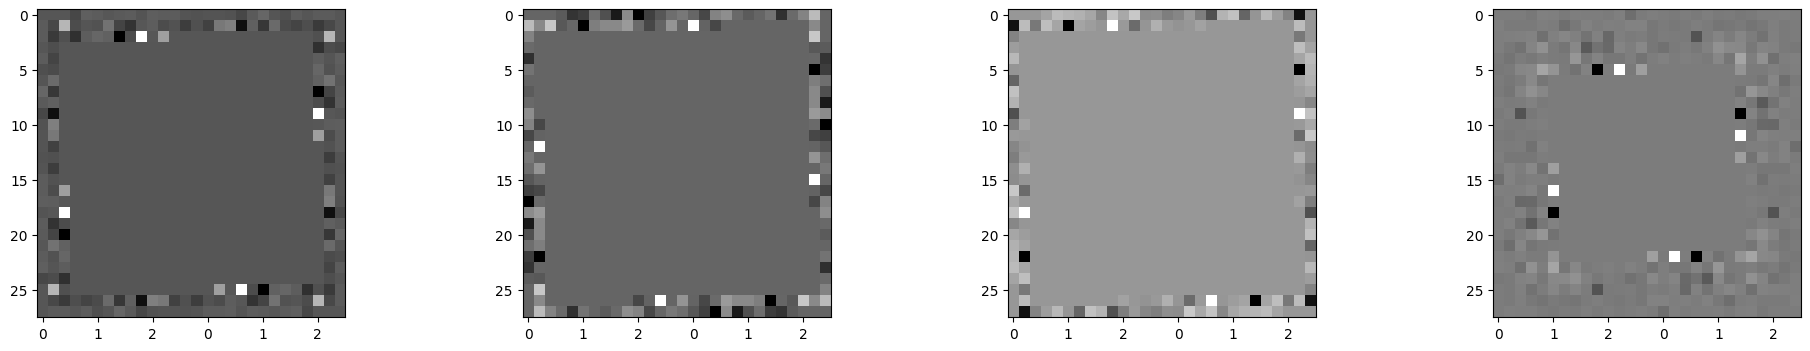

/tmp/ipykernel_16413/1135210783.py:157: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[j%maxCols].set_xticklabels([0] + [0, 1, 2] * 3)
/tmp/ipykernel_16413/1135210783.py:157: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[j%maxCols].set_xticklabels([0] + [0, 1, 2] * 3)
/tmp/ipykernel_16413/1135210783.py:157: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[j%maxCols].set_xticklabels([0] + [0, 1, 2] * 3)
/tmp/ipykernel_16413/1135210783.py:157: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[j%maxCols].set_xticklabels([0] + [0, 1, 2] * 3)


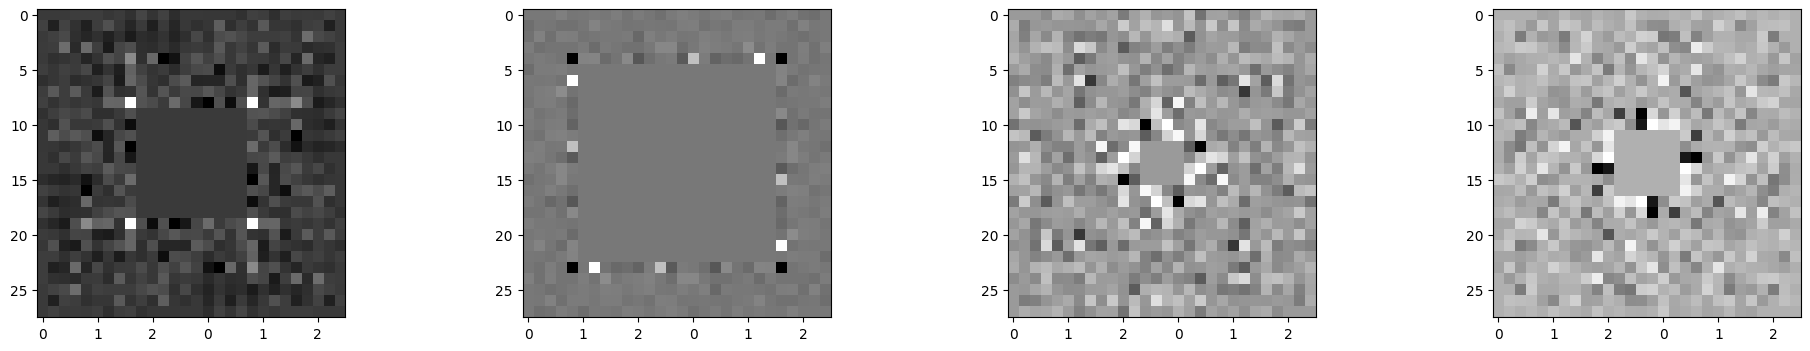

/tmp/ipykernel_16413/1135210783.py:157: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[j%maxCols].set_xticklabels([0] + [0, 1, 2] * 3)
/tmp/ipykernel_16413/1135210783.py:157: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[j%maxCols].set_xticklabels([0] + [0, 1, 2] * 3)
/tmp/ipykernel_16413/1135210783.py:157: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[j%maxCols].set_xticklabels([0] + [0, 1, 2] * 3)
/tmp/ipykernel_16413/1135210783.py:157: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[j%maxCols].set_xticklabels([0] + [0, 1, 2] * 3)


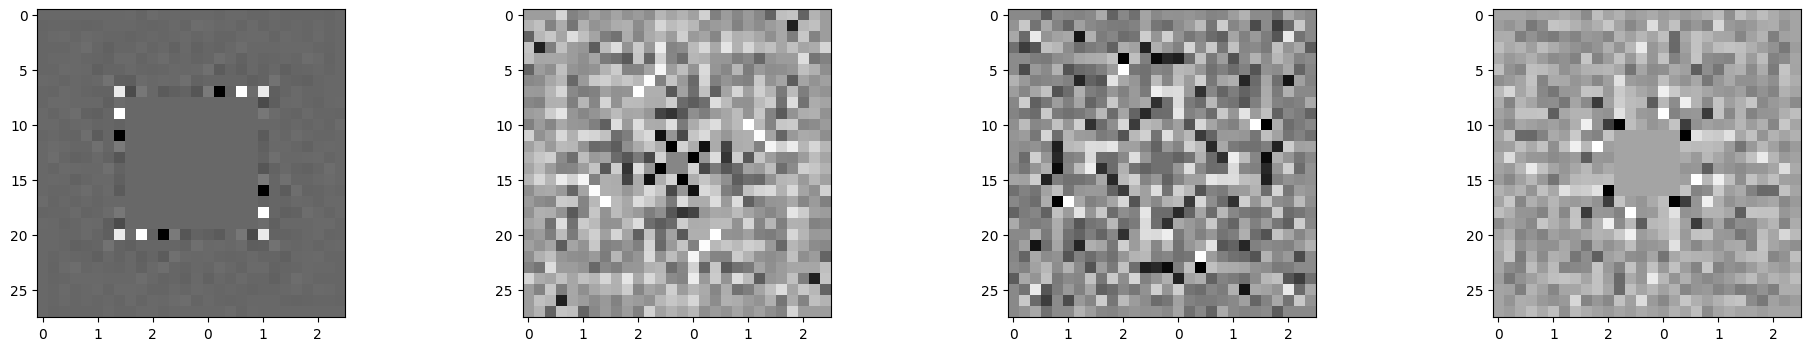

In [4]:
transform_mat, eigenvectors = get_invariant_subspace(averaged_four_rotations, (height, width))

print(f"The Reynolds operator tranformation matrix has dimension {transform_mat.shape}")
print(f"The subspace W is the subspace span by {eigenvectors.shape[1]} eigenvectors")
print("--- First 16 eigenvectors shown as images ---")
showSubspace(eigenvectors, (height, width), ndim=16, channels=False)

## Standard MLP

In [3]:
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        
        # We will later replace the first layer with a G-invariant layer.
        # Rest of the code remains the same.
        self.first_layer = nn.Linear(784, 50)
        
        self.mlp = nn.Sequential(
                self.first_layer,
                nn.ReLU(),
                nn.Linear(50, 10)
        )
                
    def forward(self, X):
        out = self.mlp(X)
        return out
        
model = MLP()

In [4]:
# Standard MLP with 1 hidden layer.
rng = torch.Generator("cpu")
rng.manual_seed(0)

# Use Pytorch's pre-defined SGD optimizer
optimizer = torch.optim.SGD(model.parameters(),lr=LR)

best_acc = 0
best_state_dict = copy.deepcopy(model.state_dict())
print("=====", "=" * 8)
print("Epoch", "Train Accuracy")
print("-----", "-" * 8)
for epc in range(NUM_EPOCHS):
    # Creates a mini-batch
    for batch_cnt, batch_itr in enumerate(
        torch.randperm(
            len(train_input),
            generator=rng,
        )[0:NUM_SAMPLES].view(
            NUM_BATCHES, BATCH_SIZE,
        ),
    ):
        # Zero gradients of optimize
        optimizer.zero_grad()
        # Forward pass of model
        train_output = model(train_input[batch_itr])
        # Define loss
        train_loss = torch.nn.functional.cross_entropy(train_output, train_target[batch_itr])
        # Backprop
        train_loss.backward()
        # One gradient step
        optimizer.step()
        
    valid_acc = accuracy(model, valid_input, valid_target)
    if (valid_acc > best_acc):
        print("{:5d} {:.6f}".format(epc + 1, valid_acc))
        best_acc = valid_acc
        best_state_dict = copy.deepcopy(model.state_dict())
    elif ((epc + 1) % 100 == 0):
        print("{:5d} {:.6f}".format(epc + 1, valid_acc))
    else:
        pass
print("=====", "=" * 8)
model.load_state_dict(best_state_dict)
train_acc = accuracy(model, train_input, train_target)
valid_acc = accuracy(model, valid_input, valid_target)
test_acc = accuracy(model, test_input, test_target)
aug_test_acc = accuracy(model, aug_test_input, aug_test_target)
print("=====", "=" * 8)
print("Data ", "\tAccuracy")
print("-----", "-" * 8)
print("Original Train", "{:.6f}".format(train_acc))
print("Original Valid", "{:.6f}".format(valid_acc))
print("Original Test ", "{:.6f}".format(test_acc))
print("Rotated  Test ", "{:.6f}".format(aug_test_acc))
print("=====", "=" * 8)


===== ========
Epoch Train Accuracy
----- --------
    1 0.841218
    2 0.887364
    3 0.902129
    4 0.912039
    5 0.916965
    6 0.920731
    7 0.923975
    8 0.930847
   11 0.933370
   13 0.933404
   15 0.936243
   16 0.937182
   17 0.938709
   18 0.938798
   20 0.939464
   21 0.940305
   22 0.941994
   23 0.942904
   26 0.943283
   27 0.944298
   31 0.944302
   33 0.945895
   38 0.947670
   49 0.947704


KeyboardInterrupt: 

In [ ]:
torch.save(model, 'mlp.pt')

## G-Invariant MLP

In [12]:
import math
eigentensor = torch.from_numpy(eigenvectors).float()

class GInvariantLayer(nn.Module):
    
    def __init__(self, input_dim, output_dim):
        super().__init__()
        
        # Load the left 1-eigenvectors of the Reynolds operator that we computed before.
        self.basis = eigentensor.T
        assert self.basis.shape[1] == input_dim
        
        self.coeffs = nn.Parameter(torch.Tensor(output_dim, self.basis.shape[0], 1))
        self.bias = nn.Parameter(torch.Tensor(output_dim))
        
        stdv = 1.0/math.sqrt(output_dim)
        self.coeffs.data.uniform_(-stdv, stdv)
        self.bias.data.zero_()
    

    def forward(self, X):
        # Input shape: torch.Size([minibatch, input_dim])
        
        if self.basis.device != X.device:
            self.basis = self.basis.to(X.device)

        # Construct weight w \in \mathcal{W} (the left 1-eigenspace)
        #      using the current learnable coefficients.
        # coeffs: (output_dim, n_basis, 1)
        # basis  : (n_basis, input_dim)
        # result after torch.mul : (output_dim, n_basis, input_dim)
        # result after sum : (output_dim, input_dim)
        weights = torch.mul(self.coeffs, self.basis)
        weights = weights.sum(dim=-2)

        # Output shape: torch.Size([minibatch, output_dim])
        out = X @ weights.T + self.bias

        return out

In [13]:
class GInvariantMLP(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Replace the first layer with a G-invariant layer.
        self.first_layer = GInvariantLayer(784, 50)
        
        self.mlp = nn.Sequential(
                self.first_layer,
                nn.ReLU(),
                nn.Linear(50, 10)
        )
                
    def forward(self, X):
        out = self.mlp(X)
        return out

        
model = GInvariantMLP()

In [14]:
# G-invariant MLP with 1 hidden layer.
rng = torch.Generator("cpu")
rng.manual_seed(0)

# Use Pytorch's pre-defined SGD optimizer
optimizer = torch.optim.SGD(model.parameters(),lr=LR)
best_acc = 0
best_state_dict = copy.deepcopy(model.state_dict())
print("=====", "=" * 8)
print("Epoch", "Train Accuracy")
print("-----", "-" * 8)
linear_transform = torch.Tensor(transform_mat.T)
for epc in range(NUM_EPOCHS):
    for batch_cnt, batch_itr in enumerate(
        torch.randperm(
            len(train_input),
            generator=rng,
        )[0:NUM_SAMPLES].view(
            NUM_BATCHES, BATCH_SIZE,
        ),
    ):
        optimizer.zero_grad()
        train_output = model.forward(
            train_input[batch_itr],
        )
        train_loss = torch.nn.functional.cross_entropy(
            train_output, train_target[batch_itr],
        )
        train_loss.backward()
        optimizer.step()
    valid_acc = accuracy(
        model,
        valid_input,
        valid_target,
    )
    if (valid_acc > best_acc):
        print("{:5d} {:.6f}".format(epc + 1, valid_acc))
        best_acc = valid_acc
        best_state_dict = copy.deepcopy(model.state_dict())
    elif ((epc + 1) % 50 == 0):
        print("{:5d} {:.6f}".format(epc + 1, valid_acc))
    else:
        pass
print("=====", "=" * 8)
model.load_state_dict(best_state_dict)
train_acc = accuracy(
    model,
    train_input,
    train_target,
)
valid_acc = accuracy(
    model,
    valid_input,
    valid_target,
)
test_acc = accuracy(
    model,
    test_input,
    test_target,
)
aug_test_acc = accuracy(
    model,
    aug_test_input,
    aug_test_target,
)
print("=====", "=" * 8)
print("Data  ", "Accuracy")
print("-----", "-" * 8)
print("Original Train", "{:.6f}".format(train_acc))
print("Original Valid", "{:.6f}".format(valid_acc))
print("Original Test ", "{:.6f}".format(test_acc))
print("Rotated  Test  ", "{:.6f}".format(aug_test_acc))
print("=====", "=" * 8)

===== ========
Epoch Train Accuracy
----- --------


KeyboardInterrupt: 

In [ ]:
torch.save(model, 'g-inv.pt')

## Inference

In [16]:
def show(img):
    plt.imshow(img, cmap='Greys', vmin=0, interpolation='nearest')
    plt.show()

In [17]:
mlp = torch.load('mlp.pt')

/tmp/ipykernel_18662/440698550.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mlp = torch.load('mlp.pt')


In [18]:
g_inv = torch.load('g-inv.pt')

/tmp/ipykernel_18662/1659664515.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  g_inv = torch.load('g-inv.pt')


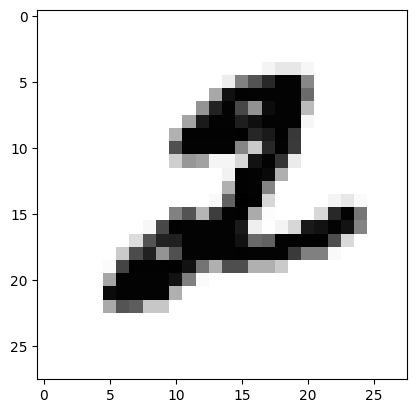

In [26]:
import random

image = train_input[random.randint(0, 100)].reshape(28, 28)
show(image)

In [27]:
rotated_image = transforms.functional.affine_image(image.unsqueeze(0), angle=-90, translate=(0,0), scale=1, shear=[0])[0]

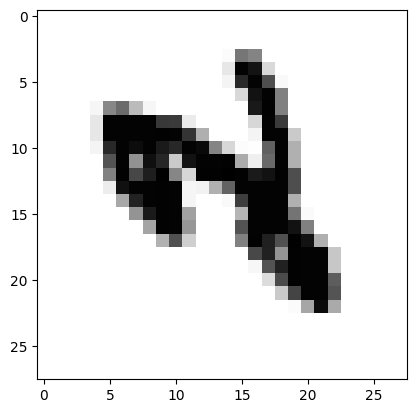

In [28]:
show(rotated_image)

In [29]:
mlp(image.ravel()).argmax()

tensor(2)

In [30]:
mlp(rotated_image.ravel()).argmax()

tensor(4)

In [40]:
import numpy as np

In [ ]:
np.allclose(g_inv(image.ravel()).numpy)

In [39]:
g_inv(image.ravel())

NameError: name 'float8' is not defined

In [34]:
g_inv(rotated_image.ravel())

tensor([ 8.9737, 10.2703, 17.6802,  9.9952, 13.4348,  5.3488,  3.9829, 13.4264,
        10.1660,  1.8351], grad_fn=<ViewBackward0>)